# Using Papermill to Execute a Digital Elevation Model and store the result in an S3 bucket

See [RFC](https://www.notion.so/sensandworkspace/RFC-Geospatial-integrations-with-a-REPL-bd5d344487234fef85e5414300e417f4) for more detail

In [1]:
#papermill_description=imports

import json
import os
import geopandas as gpd
from io import StringIO
import pystac_client
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import boto3
from botocore.exceptions import NoCredentialsError
from requests.exceptions import HTTPError
from gis_utils.stac import initialize_stac_client, query_stac_api
import rasterio.plot

# Set environment variable for AWS public datasets
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
#papermill_description=init_s3_client

def init_s3_client(aws_access_key_id, aws_secret_access_key, region_name, endpoint_url=None):
    """
    Initialize an S3 client with the specified configuration.

    Args:
        aws_access_key_id (str): AWS access key ID. For mock services, this can be any string, as authentication is not enforced.
        aws_secret_access_key (str): AWS secret access key. For mock services, this can be any string, as authentication is not enforced.
        region_name (str): The AWS region to use. This can be any valid AWS region string.
        endpoint_url (str, optional): The complete URL to the S3 service. This is typically the URL to a mock S3 service in a local development environment. Defaults to None.

    Returns:
        boto3.client: A boto3 S3 client configured to interact with the specified S3 service.
    """
    client_kwargs = {
        'aws_access_key_id': aws_access_key_id,
        'aws_secret_access_key': aws_secret_access_key,
        'region_name': region_name,
        'use_ssl': False  # S3Mock and other mock services might not use SSL
    }

    # Only add endpoint_url to the kwargs if it's provided
    if endpoint_url:
        client_kwargs['endpoint_url'] = endpoint_url

    return boto3.client('s3', **client_kwargs)

In [3]:
#papermill_description=get_bbox_from_geodf

def get_bbox_from_geodf(geojson_data):
    """
    Extract the bounding box from a GeoJSON-like dictionary.
    
    Parameters:
    - geojson_data (dict): The GeoJSON data as a Python dictionary.
    
    Returns:
    - A list representing the bounding box [min_lon, min_lat, max_lon, max_lat].
    """
    gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])
    bbox = list(gdf.total_bounds)
    return bbox


In [4]:
#papermill_description=compute_elevation_statistics

def compute_elevation_statistics(dem_data):
    """
    Compute basic elevation statistics from a digital elevation model (DEM) dataset.

    This function calculates the minimum, maximum, mean, and standard deviation of elevation
    values within the provided DEM data array. It handles the DEM data as a NumPy array,
    which is a common format for raster data in Python.

    Parameters:
    - dem_data (numpy.ndarray): A 2D NumPy array containing elevation data from a DEM raster.
      The array should contain numeric values representing elevation at each cell. No-data
      values should be represented by NaNs in the array to be properly ignored in calculations.

    Returns:
    - dict: A dictionary containing the computed elevation statistics, with keys 'min_elevation',
      'max_elevation', 'mean_elevation', and 'std_dev_elevation'.
    """

    # Compute the minimum elevation, ignoring any NaN values which represent no-data cells
    min_elevation = float(np.nanmin(dem_data))

    # Compute the maximum elevation, ignoring any NaN values
    max_elevation = float(np.nanmax(dem_data))

    # Compute the mean elevation, ignoring any NaN values
    mean_elevation = float(np.nanmean(dem_data))

    # Compute the standard deviation of elevation, ignoring any NaN values
    std_dev_elevation = float(np.nanstd(dem_data))

    # Construct and return a dictionary containing the computed statistics
    stats = {
        'min_elevation': min_elevation,
        'max_elevation': max_elevation,
        'mean_elevation': mean_elevation,
        'std_dev_elevation': std_dev_elevation
    }

    return stats

In [5]:
#papermill_description=parameters

geojson = json.dumps({
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
})
propertyName = "test"
start_date = "2023-01-01"
end_date = "2023-03-01"



{'ResponseMetadata': {'RequestId': 'WH15AP7MEZ8PTP05',
  'HostId': 'Z/TKJ9LyhFg1AKfMM9WAwbIOhDmqOZzuyD39lxxeVdvVY8D2Jh6uJW+nH9ShKhzWk6aXYWG0ZIQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Z/TKJ9LyhFg1AKfMM9WAwbIOhDmqOZzuyD39lxxeVdvVY8D2Jh6uJW+nH9ShKhzWk6aXYWG0ZIQ=',
   'x-amz-request-id': 'WH15AP7MEZ8PTP05',
   'date': 'Fri, 23 Feb 2024 05:01:02 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"17aed9a87527524cc5f04f915eb61846"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"17aed9a87527524cc5f04f915eb61846"',
 'ServerSideEncryption': 'AES256'}

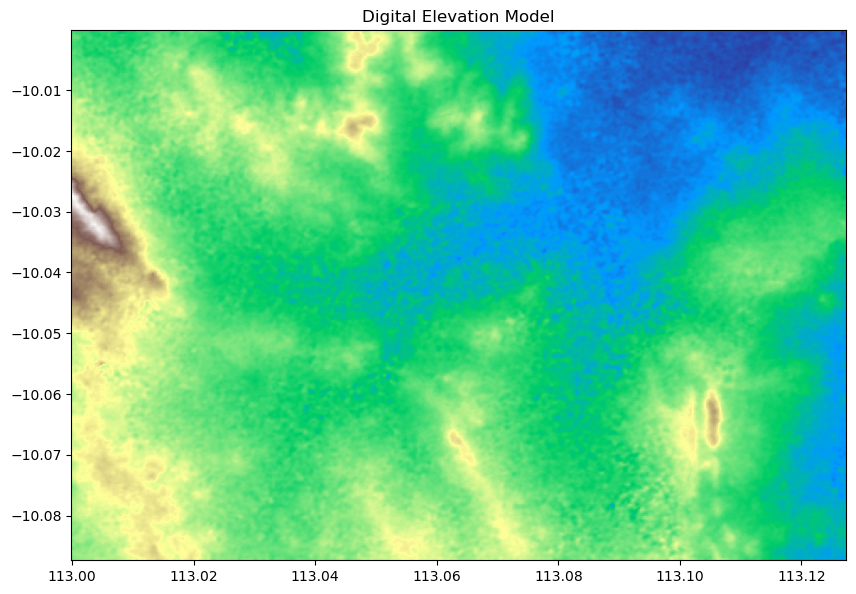

In [7]:
#papermill_description=processing

# Load AWS credentials from environment variables
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
region_name = 'us-east-1'

# Construct the filenames using propertyName
elevation_json_filename = f"dem_{propertyName}_elevation_stats.json"
output_tiff_filename = f"dem_{propertyName}.tiff"

s3_client = init_s3_client(aws_access_key_id=aws_access_key_id,
                           aws_secret_access_key=aws_secret_access_key,
                           region_name=region_name)

req = json.loads(geojson)
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

stac_url_dem = "https://explorer.sandbox.dea.ga.gov.au/stac/"
stac_url_rgb = "https://earth-search.aws.element84.com/v1"
collections_dem = ['ga_srtm_dem1sv1_0']
collections_rgb = ['sentinel-2-l2a']

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

# Get bounding box from GeoJSON
bbox = get_bbox_from_geodf(geojson_data)

# Initialize STAC clients
client_dem = initialize_stac_client(stac_url_dem)
client_rgb = initialize_stac_client(stac_url_rgb)

start_date = "2023-01-01"
end_date = "2023-03-01"

# Query STAC catalogs
items_dem = query_stac_api(client_dem, bbox, collections_dem, None, None)
items_rgb = query_stac_api(client_rgb, bbox, collections_rgb, start_date, end_date)

# Only want the dem asset
item = items_dem[0]
dem_asset = item.assets.get('dem')

# Fallback DEM URL
fallback_dem_href = 'https://dea-public-data.s3-ap-southeast-2.amazonaws.com/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif'

# Process the dem asset
with rasterio.open(fallback_dem_href) as src:
    # Convert the GeoJSON bounds to a rasterio window
    window = from_bounds(*bbox, transform=src.transform)

    # Read the data within the window
    data = src.read(window=window)

    # Preserve the metadata from the dem asset
    kwargs = src.meta.copy()
    # Updating the metadata based on the bounding box of our original geojson
    kwargs.update({
        'height': window.height,
        'width': window.width,
        'transform': rasterio.windows.transform(window, src.transform)
    })
    
    with rasterio.open(output_tiff_filename, 'w', **kwargs) as dst:
        dst.write(data)
        

elevation_stats = compute_elevation_statistics(data)

# Plot the data using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(data, transform=src.transform, ax=ax, cmap='terrain')
ax.set_title('Digital Elevation Model')

# Serialize 'elevation_stats' to a JSON string
elevation_stats_json = json.dumps(elevation_stats)
# Convert the JSON string to bytes
elevation_stats_bytes = elevation_stats_json.encode()

s3_client.upload_file(output_tiff_filename, 'jenna-remote-sensing-sandbox', output_tiff_filename)
s3_client.put_object(
    Body=elevation_stats_bytes,
    Bucket='jenna-remote-sensing-sandbox',
    Key=elevation_json_filename
)
